In [1]:
from kmeans.gensim_kmeans import KMeans
from preprocess import load_model
from pprint import pprint
import torch

加载模型，维数为20

In [2]:
corpus_t, dictionary_t, tfidf_t, lsi_t, mSimilar_t = load_model("./preprocess/model/")
corpus, dictionary, tfidf, lsi, mSimilar = load_model("./preprocess/model_test/")

2021-04-11 09:33:55,742 : INFO : loaded corpus index from ./preprocess/model/corpus.mm.index
2021-04-11 09:33:55,742 : INFO : initializing cython corpus reader from ./preprocess/model/corpus.mm
2021-04-11 09:33:55,758 : INFO : accepted corpus with 9804 documents, 255478 features, 6928768 non-zero entries
2021-04-11 09:33:55,758 : INFO : loading Dictionary object from ./preprocess/model/model.dic
2021-04-11 09:33:56,063 : INFO : Dictionary lifecycle event {'fname': './preprocess/model/model.dic', 'datetime': '2021-04-11T09:33:56.063711', 'gensim': '4.0.1', 'python': '3.9.2 (tags/v3.9.2:1a79785, Feb 19 2021, 13:44:55) [MSC v.1928 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19041-SP0', 'event': 'loaded'}
2021-04-11 09:33:56,063 : INFO : loading TfidfModel object from ./preprocess/model/model.tfidf
2021-04-11 09:33:56,374 : INFO : TfidfModel lifecycle event {'fname': './preprocess/model/model.tfidf', 'datetime': '2021-04-11T09:33:56.374068', 'gensim': '4.0.1', 'python': '3.9.2 (tags/v3.

In [3]:
X = lsi[tfidf[corpus]]
X_t = lsi_t[tfidf_t[corpus_t]]

转换成列表，矩阵和Tensor的形式

In [4]:
from training_utils import get_list
import numpy as np

X_list = get_list(X)
X_array = np.array(X_list)
X_torch = torch.from_numpy(X_array)

In [5]:
from training_utils import get_list
import numpy as np

X_list_t = get_list(X_t)
X_array_t = np.array(X_list_t)
X_torch_t = torch.from_numpy(X_array_t)

In [6]:
import torch

if torch.cuda.is_available():
    device = torch.device('cuda:0')
else:
    device = torch.device('cpu')


加载正确的标签

In [7]:
from file_utils import get_files

f_list = get_files("./corpus/test/")
l = np.array([int(i.split("\\")[-1].split("-")[0][1:]) for i in f_list])
f_list = get_files("./corpus/train/")
l_t = np.array([int(i.split("\\")[-1].split("-")[0][1:]) for i in f_list])

使用以下代码尝试寻找最优的`random_state`

In [8]:
from training_utils import best_map

max_acc = 0
max_i = -1
# train 629
# test 98
for i in range(100):
    kmeans = KMeans(20, random_state=i, device=device)
    label, _ = kmeans.fit_predict(X, mSimilar, X_array, X_torch)
    acc, _ = best_map(l, label.numpy())
    if acc > max_acc:
        max_acc = acc
        max_i = i
    if acc > 0.50:
        print(i, acc)
print("max", max_i, max_acc)

98 0.5020341741253052
max 98 0.5020341741253052


在测试集上试验结果，并对结果进行评价
各项评价指标，包括**互信息**，**兰德系数**

In [8]:
from training_utils import best_map
from kmeans.gensim_kmeans import KMeans
from training_utils import scores

kmeans = KMeans(20, random_state=98, device=device)
label, _ = kmeans.fit_predict(X, mSimilar, X_array, X_torch)
acc, label_pred = best_map(l, label.numpy())
print("准确率:", acc)
scores(l, label_pred)

准确率: 0.5020341741253052
互信息：1.443762019930632
调整互信息：0.5658882037470625
标准化互信息：0.569235759920096
兰德系数： 0.4412628417309452


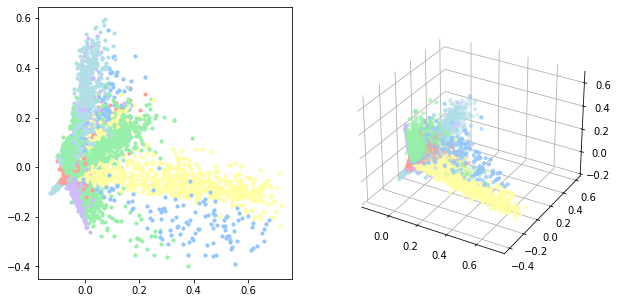

In [9]:
from training_utils import draw

draw(X_array, label)

在训练集上进行试验，并对结果进行评价

In [10]:
from training_utils import best_map
from training_utils import scores

kmeans = KMeans(20, random_state=629, device=device)
label_t, _ = kmeans.fit_predict(X_t, mSimilar_t, X_array_t, X_torch_t)
acc, label_pred = best_map(l_t, label_t.numpy())
print("准确率:", acc)
scores(l_t, label_pred)

准确率: 0.5042839657282742
互信息：1.3995792709892958
调整互信息：0.5521038444098715
标准化互信息：0.5555647814666083
兰德系数： 0.4380890094891669


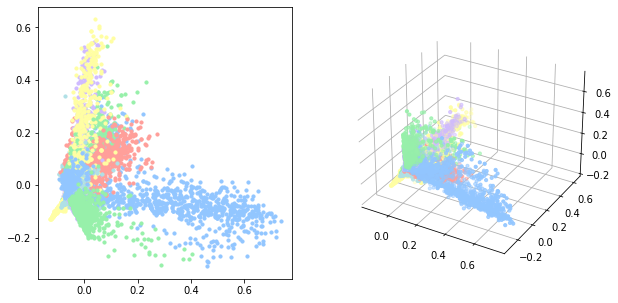

In [11]:
from training_utils import draw

draw(X_array_t, label_t)

使用训练集对进行聚类，并将测试集输入获取其每一个样本所在类别

In [14]:
from training_utils import best_map
from training_utils import scores

kmeans = KMeans(20, random_state=102, device=device)
model = kmeans.fit(X_t, mSimilar_t, X_array_t, X_torch_t)
label_t = model.predict(mSimilar)
acc, label_pred = best_map(l, label_t.numpy())
print("准确率:", acc)
scores(l, label_pred)

准确率: 0.5100691619202604
互信息：1.1488225130634917
调整互信息：0.4880283028337565
标准化互信息：0.49150166852558225
兰德系数： 0.3665762157017865


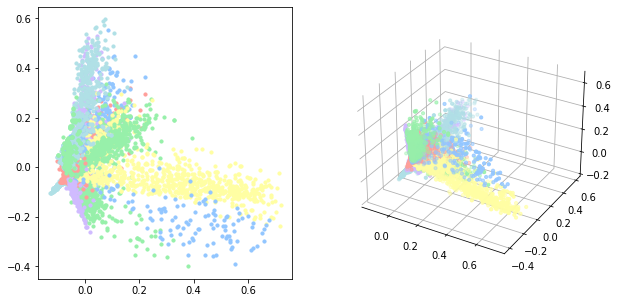

In [15]:
from training_utils import draw

draw(X_array, label)